# QCoDeS Example with HP8753D

This is the example notebook illustrating how to use the QCoDeS driver for the HP 8753D Network Analyzer.

Throughout the notebook, we assume that a Mini-Circuits SLP-450+ Low Pass filter is connected as the DUT. The test setup is as the following picture:

![title](../files/HP8753D.png)

### Required imports

In [1]:
from qcodes.instrument_drivers.HP.HP8753D import HP8753D
from qcodes.utils.dataset import doNd
import time

### Connecting to the instrument and running the test

In [2]:
vna = HP8753D('vna', 'GPIB0::15::INSTR')

Connected to: HEWLETT PACKARD 8753D (serial:0, firmware:6.14) in 0.22s


For the sake of this tutorial, we reset the instrument

In [3]:
vna.reset()

Let's look at the current snapshot of the instrument:

In [4]:
vna.print_readable_snapshot(update=True)

vna:
	parameter         value
--------------------------------------------------------------------------------
IDN                :	{'vendor': 'HEWLETT PACKARD', 'model': '8753D', 'serial'...
averaging          :	OFF 
display_format     :	Log mag 
display_reference  :	0 (dB)
display_scale      :	10 (dB)
number_of_averages :	16 
output_power       :	0 (dBm)
s_parameter        :	S11 
start_freq         :	30000 (Hz)
stop_freq          :	6e+09 (Hz)
sweep_time         :	0.175 (s)
timeout            :	10 (s)
trace              :	Not available 
trace_points       :	201 


We setup the test such as the low-pass filter is connecting Port 1 to Port2. Let's setup the trace of S21 with 10 averages with a frequency range from 100 kHz to 1 GHz on a linear scale. Then, the instrument settings are as below:

In [5]:
vna.display_format('Lin mag')
vna.s_parameter('S21')
vna.start_freq(100e3)
vna.stop_freq(1e9)

# and let's adjust the y-scale to fit
vna.display_scale(0.12)
vna.display_reference(-0.1)

# and finally enable averaging
vna.averaging('ON')
vna.number_of_averages(10)

### Single trace measurement

Now we aquire a single trace. Before each aqcuisition, we must run prepare_trace for the instrument trace:

Starting experimental run with id: 163. 


(results #163@C:\Users\QCoDeS_Public\experiments.db
 --------------------------------------------------
 vna_Frequency - array
 vna_trace - array,
 [None])

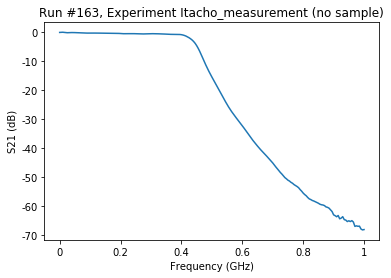

In [6]:
vna.trace.prepare_trace()
doNd.do0d(vna.trace)

### Acquiring traces while sweeping

Now we will vary the output power and acquire a trace for each power to examine how applying more power reduces the measurement noise.
We have to ensure that the vna finishes averaging before moving to the next power step. Therefore, we setup a function to do this average and pass it to our measurement setup (note that this function can be implemented in several different ways)

In [7]:
n_avgs = 10
vna.number_of_averages(n_avgs)
def run_sweeper():
    vna.run_N_times(n_avgs)

We prepare our trace and run the sweep and time it:

Starting experimental run with id: 164. 


72.79213905334473

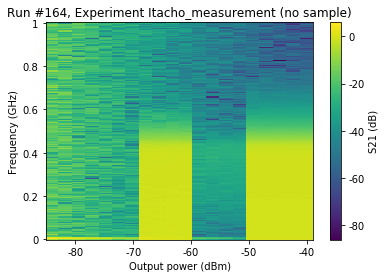

In [8]:
vna.trace.prepare_trace()
t1 = time.time()
doNd.do1d(vna.output_power, -84, -40, 20, 0.1, run_sweeper,vna.trace)
t2 = time.time()
t2-t1

n_avgs can be changed between 1 and 999 (the higher average, more detailed result and longer time to finish)

In [9]:
vna.close()